In [1]:
# Import pkgs

In [2]:
# pip install imgaug --user

In [3]:
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
User_name=u'沈易達'


Segmentation Models: using `tf.keras` framework.


In [4]:
#pip install -U segmentation-models


In [5]:
# pip install h5py==2.10.0

In [6]:
# pip list


In [7]:
tf.compat.v1.disable_eager_execution()


In [8]:

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
import numpy as np

from lib.augmentation import get_training_augmentation, get_validation_augmentation, get_preprocessing
from lib.data_loader import Dataset, Dataloder
from lib.visualization import visualize
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sm.set_framework('tf.keras')
sm.framework()
print("TF version: {}.".format(tf.__version__))
print("Keras version: {}.".format(keras.__version__))


TF version: 2.1.0.
Keras version: 2.2.4-tf.


In [9]:
from lib.parallel_model import*

In [10]:
from tensorflow.python.client import device_lib
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
            
solve_cudnn_error()
def get_gpus():
    info = device_lib.list_local_devices()
    return [x.physical_device_desc for x in info if x.device_type == "GPU"]


get_gpus()

[]

In [11]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [12]:
# os.chdir("D:/SurgeryAnalytics/AI_Cases/Dentistry0929/B_AI_training")
# cwd = os.getcwd()
print('change directory 配合使用使 os.getcwd() 可正確顯示Start')
#os.chdir(os.path.dirname(os.path.abspath(__file__)))  #ipynb 不可用
from pathlib import Path  #改為目前的資料夾引用物件
os.chdir(Path.cwd())    #改為目前的資料夾*********
cwd = os.getcwd()
print(cwd)
print('change directory 配合使用使 os.getcwd() 可正確顯示End')
# print(cwd)
AI_Path = cwd.split('/B_AI_training')[0]
# print(AI_Path)

AI_Data_jsonFile=AI_Path+'/A_Data_preprocessing/Dentistry_config.json'
# if not os.path.isdir(trans_folder_path):
#     os.mkdir(trans_folder_path)


change directory 配合使用使 os.getcwd() 可正確顯示Start
/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/Dentistry_AI_ZERO_New_1120105/B_AI_training
change directory 配合使用使 os.getcwd() 可正確顯示End


# Set parameters

In [13]:
import json
# jsonFile = r"f:\SurgeryAnalytics/AI_Cases/Dentistry/1_Linknet_efficientnetb7_0_3/A_Data_preprocessing/Dentistry_config.json"  #讀取剛剛資料分析完輸出的JSION檔
jsonFile = AI_Data_jsonFile  #讀取剛剛資料分析完輸出的JSION檔
with open(jsonFile, 'r') as f:
    config = json.load(f)
config["user_name"] = User_name

In [14]:
config

{'surgeryName': 'Dentistry',
 'label_folder_path': '/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/Dentistry_AI_ZERO_New_1120105/0_Data/0_ori',
 'trans_folder_path': '/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/Dentistry_AI_ZERO_New_1120105/0_Data/1_trans',
 'split_folder_path': '/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/Dentistry_AI_ZERO_New_1120105/0_Data/2_split',
 'correct_label': ['Alveolar_bone',
  'Caries',
  'Crown',
  'Dentin',
  'Enamel',
  'Implant',
  'Mandibular_alveolar_nerve',
  'Maxillary_sinus',
  'Periapical_lesion',
  'Post_and_core',
  'Pulp',
  'Restoration',
  'Root_canal_filling'],
 'detect_label_list': ['Alveolar_bone',
  'Caries',
  'Crown',
  'Dentin',
  'Enamel',
  'Implant',
  'Mandibular_alveolar_nerve',
  'Maxillary_sinus',
  'Periapical_lesion',
  'Post_and_core',
  'Pulp',
  'Restoration',
  'Root_canal_filling'],
 'Data_total_excel': '/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/D

# 下面主要　建立　Model & Backbone & BATCH_SIZE

In [15]:
import copy
# data path
DATA_DIR = config["split_folder_path"]
x_train_dir = os.path.join(DATA_DIR, 'train', 'img')
y_train_dir = os.path.join(DATA_DIR, 'train', 'label')

x_valid_dir = os.path.join(DATA_DIR, 'val', 'img')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'label')

# Label information
## data_loader must be change also.
CLASSES = copy.deepcopy(config["correct_label"])

CLASSES.insert(0, "background")


# hyperparameters
MODEL = 'Linknet' # 使用的model名稱 (Unet/Linknet/PSPNet/FPN)
BACKBONE = 'efficientnetb7' # resnet152 efficientnetb0 使用的backbone名稱 (efficientnetb4/efficientnetb5/resnet101/mobilenetv2/NASNetLarge/inceptionresnetv2/efficientnetb7...)
# BACKBONE models: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 
#                    'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 
#                    'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 
#                    'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
data_height=384
data_width=384
# data_height=480
# data_width=640

if MODEL == 'PSPNet':
    data_height=384
    data_width=384
    tf.compat.v1.disable_eager_execution()


BATCH_SIZE = 4

LR = 0.0001 #0.0001
EPOCHS = 100 #40
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
optim = keras.optimizers.Adam(LR)

preprocess_input = sm.get_preprocessing(BACKBONE)

# loss
# WEIGHT = np.array([0.01, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.01])
# WEIGHT = np.empty(0)
jaccard_loss = sm.losses.JaccardLoss()#(class_weights=WEIGHT)
dice_loss = sm.losses.DiceLoss()#class_weights=WEIGHT)    沒用到????
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# categorical_crossentropy = sm.losses.CategoricalCELoss(class_weights=WEIGHT)
total_loss = (0.5 * jaccard_loss) + (1 * focal_loss)
# print(total_loss)
# metrics
metrics = [sm.metrics.IOUScore(threshold=0.5), # , class_indexes=[1]
           sm.metrics.Recall(threshold=0.5)] # , class_indexes=[1]]

# metrics = [sm.metrics.IOUScore(threshold=0.5), # , class_indexes=[1]
#            sm.metrics.Recall(threshold=0.5), # , class_indexes=[1]
#           "sparse_categorical_accuracy"]

In [16]:
# print(jaccard_loss)

In [17]:
#pip install -U albumentations

In [18]:
#pip install albumentations --user

# View data labeled

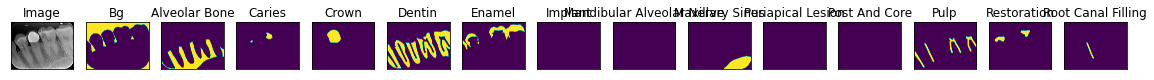

In [19]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)
image, mask = dataset[75] # get some sample

visualize(
    image=image, 
    bg=mask[..., 0].squeeze(),
    Alveolar_bone=mask[..., 1].squeeze(),
    Caries=mask[..., 2].squeeze(),
    Crown=mask[..., 3].squeeze(),
    Dentin=mask[..., 4].squeeze(),
    Enamel=mask[..., 5].squeeze(),
    Implant=mask[..., 6].squeeze(),
    Mandibular_alveolar_nerve=mask[..., 7].squeeze(),
    Maxillary_sinus=mask[..., 8].squeeze(),
    Periapical_lesion=mask[..., 9].squeeze(),
    Post_and_core=mask[..., 10].squeeze(),
    Pulp=mask[..., 11].squeeze(),
    Restoration=mask[..., 12].squeeze(),
    Root_canal_filling=mask[..., 13].squeeze()

)
# print(mask.shape)
# print(image.shape)

/home/ai/.local/lib/python3.6/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/ai/.local/lib/python3.6/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/home/ai/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/ai/.local/lib/python3.6/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/ai/.local/lib/python3

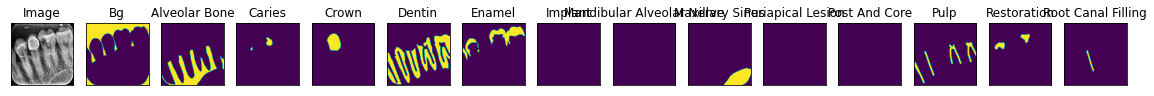

In [20]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES, augmentation=get_training_augmentation(data_height,data_width))
# augmentation 主要在進行 少量資料的複雜化 
image, mask = dataset[75] # get some sample

visualize(
    image=image, 
    bg=mask[..., 0].squeeze(),
    Alveolar_bone=mask[..., 1].squeeze(),
    Caries=mask[..., 2].squeeze(),
    Crown=mask[..., 3].squeeze(),
    Dentin=mask[..., 4].squeeze(),
    Enamel=mask[..., 5].squeeze(),
    Implant=mask[..., 6].squeeze(),
    Mandibular_alveolar_nerve=mask[..., 7].squeeze(),
    Maxillary_sinus=mask[..., 8].squeeze(),
    Periapical_lesion=mask[..., 9].squeeze(),
    Post_and_core=mask[..., 10].squeeze(),
    Pulp=mask[..., 11].squeeze(),
    Restoration=mask[..., 12].squeeze(),
    Root_canal_filling=mask[..., 13].squeeze()

)

# print(mask.shape)

In [21]:
#pip install -U albumentations --no-binary qudida,albumentations

In [22]:
#pip install -U albumentations[imgaug]

#pip install -U albumentations

# Model training

In [23]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(data_height,data_width),
    preprocessing=get_preprocessing(preprocess_input),
)
# augmentation 主要在進行 少量資料的複雜化 

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(data_height,data_width),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
# print(train_dataloader.shap)
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, data_height, data_width, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, data_height, data_width, n_classes)
# assert train_dataloader[0][0].shape == (1, data_height, data_width, 3)
# assert train_dataloader[0][1].shape == (1, data_height, data_width, n_classes)
assert valid_dataloader[0][0].shape == (1, data_height, data_width, 3)
assert valid_dataloader[0][1].shape == (1, data_height, data_width, n_classes)

In [24]:
def my_scheduler(epoch, lr):
    if epoch < 300:
        return lr
    else:
        return 0.00001 # lr * tf.math.exp(-0.1)

In [25]:
import time
time.localtime()
train_time=time.strftime("%Y%m%d%H%M%S", time.localtime())
#訓練資料H5存入的資料夾 save_ckpt_Folder  memo by charley



In [26]:
print(train_time) #測試用1110825

20230112150843


In [27]:
# GPU_COUNT = 1 # 同时使用3个GPU
# model = keras.applications.densenet.DenseNet201() # 比如使用DenseNet-201
# model = ParallelModel(model, GPU_COUNT)
# model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics = ['accuracy'])
# model.fit(X_train, y_train,
#               batch_size=batch_size*GPU_COUNT, 
#               epochs=nb_epoch, verbose=0, shuffle=True,
#               validation_data=(X_valid, y_valid))

# model.save_weights('/path/to/save/model.h5')

In [28]:
# print(valid_dataloader[46][1].shape)

In [29]:
CKPT_PATH = ""
exec('model = sm.' + MODEL +'(BACKBONE, classes=n_classes, activation=activation)')
# GPU_COUNT = 1 # 同时使用3个GPU   
# model = ParallelModel(model, GPU_COUNT)    
if CKPT_PATH != '':
    model.load_weights(CKPT_PATH)
model.compile(optim, total_loss, metrics)
# dirPath = os.getcwd()
# save_model_path = dirPath + "/ckpt/"+train_time
# if not os.path.isdir(save_model_path):
#     os.mkdir(save_model_path)
# callbacks = [
#     # monitor='val_iou_score', mode='max' # mode='min'
#     keras.callbacks.ModelCheckpoint(save_model_path + '/'+ MODEL+'_'+BACKBONE +'_n{epoch:02d}_{val_iou_score:.3f}_model.h5', save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min'),
#     keras.callbacks.ReduceLROnPlateau(patience=12, verbose=1), # patience=12, min_lr=0.00001
#     # keras.callbacks.LearningRateScheduler(schedule=my_scheduler, verbose=1)
#     keras.callbacks.CSVLogger(MODEL+"_"+BACKBONE+'_model_adam.csv')
# ]

# history = model.fit_generator(
#     train_dataloader, 
#     steps_per_epoch=len(train_dataloader),
#     epochs=EPOCHS, 
#     callbacks=callbacks, 
#     validation_data=valid_dataloader, 
#     validation_steps=len(valid_dataloader),
# )



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [30]:
dirPath = os.getcwd()
save_model_path = dirPath + "/ckpt/"+train_time
if not os.path.isdir(save_model_path):
    os.mkdir(save_model_path)
callbacks = [
    # monitor='val_iou_score', mode='max' # mode='min'
    keras.callbacks.ModelCheckpoint(save_model_path + '/'+ MODEL+'_'+BACKBONE +'_n{epoch:02d}_{val_iou_score:.3f}_model.h5', save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min'),
    keras.callbacks.ReduceLROnPlateau(patience=12, verbose=1), # patience=12, min_lr=0.00001
    # keras.callbacks.LearningRateScheduler(schedule=my_scheduler, verbose=1)
    keras.callbacks.CSVLogger(MODEL+"_"+BACKBONE+'_model_adam.csv')
]

In [31]:
weight_saver = keras.callbacks.ModelCheckpoint(save_model_path + '/'+ MODEL+'_'+BACKBONE +'_n{epoch:02d}_{val_iou_score:.3f}_model.h5', save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
CSVLogger=keras.callbacks.CSVLogger(MODEL+"_"+BACKBONE+'_model_adam.csv')
ReduceLROnPlateau=keras.callbacks.ReduceLROnPlateau(patience=12, verbose=1)

In [32]:
# print(len(train_dataloader))
# print(len(valid_dataloader))
# history = model.fit_generator(
#     train_dataloader, 
#     steps_per_epoch=len(train_dataloader),
#     epochs=EPOCHS, 
#     callbacks=callbacks, 
#     validation_data=valid_dataloader, 
#     validation_steps=len(valid_dataloader)
# )
steps_per_epoch=len(train_dataloader)
# history = model.fit(train_dataloader,
#                  validation_data = valid_dataloader,
#                  epochs=EPOCHS,
#                  callbacks = [weight_saver, earlystop,CSVLogger,ReduceLROnPlateau])

history = model.fit(train_dataloader,
                 validation_data = valid_dataloader,
                 epochs=EPOCHS,
                 callbacks = callbacks)




Epoch 1/100
496/496 [==============================] - 3594s 7s/step - loss: 0.4522 - iou_score: 0.4514 - recall: 0.5156 - val_loss: 0.4081 - val_iou_score: 0.7052 - val_recall: 0.7482
Epoch 2/100
496/496 [==============================] - 3221s 6s/step - loss: 0.3719 - iou_score: 0.6107 - recall: 0.7094 - val_loss: 0.3695 - val_iou_score: 0.7807 - val_recall: 0.8442
Epoch 3/100
496/496 [==============================] - 3222s 6s/step - loss: 0.3457 - iou_score: 0.6548 - recall: 0.7601 - val_loss: 0.3586 - val_iou_score: 0.7977 - val_recall: 0.8695
Epoch 4/100
496/496 [==============================] - 3217s 6s/step - loss: 0.3242 - iou_score: 0.6828 - recall: 0.8112 - val_loss: 0.3492 - val_iou_score: 0.7988 - val_recall: 0.8866
Epoch 5/100
496/496 [==============================] - 3218s 6s/step - loss: 0.3140 - iou_score: 0.6913 - recall: 0.8288 - val_loss: 0.3443 - val_iou_score: 0.8028 - val_recall: 0.8971
Epoch 6/100
496/496 [==============================] - 3213s 6s/step - loss

In [33]:
#import os

In [34]:
print('change directory 配合使用使 os.getcwd() 可正確顯示Start')
#os.chdir(os.path.dirname(os.path.abspath(__file__)))  #ipynb 不可用
from pathlib import Path  #改為目前的資料夾引用物件
os.chdir(Path.cwd())    #改為目前的資料夾*********
cwd = os.getcwd()
print(cwd)
print('change directory 配合使用使 os.getcwd() 可正確顯示End')
# save_model_path = dirPath + "/ckpt"
config["model"] = MODEL
config["BACKBONE"] = BACKBONE
config["num_classes"] = len(CLASSES)+1
config["save_ckpt_Folder"] = save_model_path
config["data_height"] = data_height
config["data_width"] = data_width
with open("Dentistry_config.json","w") as f:
    json.dump(config, f)

change directory 配合使用使 os.getcwd() 可正確顯示Start
/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/Dentistry_AI_ZERO_New_1120105/B_AI_training
change directory 配合使用使 os.getcwd() 可正確顯示End


In [35]:
config

{'surgeryName': 'Dentistry',
 'label_folder_path': '/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/Dentistry_AI_ZERO_New_1120105/0_Data/0_ori',
 'trans_folder_path': '/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/Dentistry_AI_ZERO_New_1120105/0_Data/1_trans',
 'split_folder_path': '/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/Dentistry_AI_ZERO_New_1120105/0_Data/2_split',
 'correct_label': ['Alveolar_bone',
  'Caries',
  'Crown',
  'Dentin',
  'Enamel',
  'Implant',
  'Mandibular_alveolar_nerve',
  'Maxillary_sinus',
  'Periapical_lesion',
  'Post_and_core',
  'Pulp',
  'Restoration',
  'Root_canal_filling'],
 'detect_label_list': ['Alveolar_bone',
  'Caries',
  'Crown',
  'Dentin',
  'Enamel',
  'Implant',
  'Mandibular_alveolar_nerve',
  'Maxillary_sinus',
  'Periapical_lesion',
  'Post_and_core',
  'Pulp',
  'Restoration',
  'Root_canal_filling'],
 'Data_total_excel': '/home/ai/notebook/jupyter_work/test1/SurgeryAnalytics/AI_Cases/D

In [36]:
# steps_per_epoch=len(x_train)/batch_size      这个参数实际上就是指定了每一轮epoch需要执行多少steps，也就是多少steps，才能认为一轮epoch结束。 

In [37]:
#pip install albumentations --user

In [38]:
pip list

Package                Version
---------------------- -----------
absl-py                1.3.0
albumentations         1.3.0
anyio                  3.6.2
argon2-cffi            21.3.0
argon2-cffi-bindings   21.2.0
astor                  0.8.1
async-generator        1.10
attrs                  22.1.0
Babel                  2.11.0
backcall               0.2.0
bleach                 4.1.0
cached-property        1.5.2
cachetools             4.2.4
certifi                2021.5.30
cffi                   1.15.1
charset-normalizer     2.0.12
contextvars            2.4
cycler                 0.11.0
dataclasses            0.8
decorator              4.4.2
defusedxml             0.7.1
efficientnet           1.0.0
entrypoints            0.4
et-xmlfile             1.1.0
gast                   0.2.2
google-auth            1.35.0
google-auth-oauthlib   0.4.6
google-pasta           0.2.0
grpcio                 1.48.2
h5py                   2.10.0
idna                   3.4
image-classifiers      1.0.0
i